##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Gemini 2.0 - Grounding using Search as a tool

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Search_Grounding.ipynb"><img src="https://ai.google.dev/site-assets/images/docs/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In this notebook you will learn how to use the new Google Search tool available in [Gemini 2.0](https://ai.google.dev/gemini-api/docs/models/gemini-v2), using both the unary API and the Multimodal Live API. Check out the docs to learn more about using [Search as a tool](https://ai.google.dev/gemini-api/docs/models/gemini-v2#search-tool).

Note that the previous version of this guide using Gemini models priori to 2.0 and the legacy SDK can still be found [here](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/quickstarts/Search_Grounding.ipynb).

## Set up the SDK

This guide uses the [`google-genai`](https://pypi.org/project/google-genai) Python SDK to connect to the Gemini 2.0 models.

### Install SDK

The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides programmatic access to Gemini 2 (and previous models) using both the [Google AI for Developers](https://ai.google.dev/gemini-api/docs/models/gemini-v2) and [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview) APIs. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

More details about this new SDK on the [documentation](https://googleapis.github.io/python-genai/) or in the [Getting started](get_started.ipynb) notebook.

In [1]:
!pip install -U -q google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 4.3 MB/s eta 0:00:00


### Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/gemini-api-cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [2]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

The client will pick up your API key from the environment variable.
To use the live API you need to set the client version to `v1alpha` and use the Gemini 2.0 model.

In [3]:
from google import genai

client = genai.Client(http_options={'api_version': 'v1alpha'})

MODEL = 'gemini-2.0-flash-exp'

## Use search in chat

Start by defining a helper function that you will use to display each part of the returned response.

In [4]:
# @title Define some helpers (run this cell)
import json

from IPython.display import display, HTML, Markdown


def show_json(obj):
  print(json.dumps(obj.model_dump(exclude_none=True), indent=2))

def show_parts(r):
  parts = r.candidates[0].content.parts
  if parts is None:
    finish_reason = r.candidates[0].finish_reason
    print(f'{finish_reason=}')
    return
  for part in r.candidates[0].content.parts:
    if part.text:
      display(Markdown(part.text))
    elif part.executable_code:
      display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    else:
      show_json(part)

  grounding_metadata = r.candidates[0].grounding_metadata
  if grounding_metadata and grounding_metadata.search_entry_point:
    display(HTML(grounding_metadata.search_entry_point.rendered_content))


First try a query that needs realtime information, so you can see how the model performs _without_ Google Search.

In [5]:
chat = client.chats.create(model=MODEL)

r = chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')
show_parts(r)

To determine who won the most recent Australia vs. Chinese Taipei game, I need to know which sport you are referring to. Could you please specify the sport?


Now set up a new chat session that uses the `google_search` tool.  The `show_parts` helper will display the text output as well as any Google Search queries used in the results.

In [6]:
search_tool = {'google_search': {}}
soccer_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

r = soccer_chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')
show_parts(r)

The most recent game between Australia and Chinese Taipei was on December 7, 2024, with Australia winning 6-0.


As you are using a `chat` session, you can ask the model follow-up questions too.

In [7]:
r = soccer_chat.send_message('Who scored the goals?')
show_parts(r)

The goalscorers in the Australia vs. Chinese Taipei match on December 7, 2024, were:

*   **Leah Davidson**
*   **Tameka Yallop**
*   **Emily Gielnik**
*   **Michelle Heyman**
*   **Tash Prior**
*   **Sharn Freier**


## Plot search results


In this example you can see how to use the Google Search tool with code generation in order to plot results.

In [8]:
movie_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

r = movie_chat.send_message('Generate some Python code to plot the runtimes of the last 10 Denis Villeneuve movies.')
show_parts(r)

```python
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes)
movie_titles = [
    "Dune: Part Two",
    "Dune",
    "Blade Runner 2049",
    "Arrival",
    "Sicario",
    "Prisoners",
    "Enemy",
    "Incendies",
    "Polytechnique",
    "Maelström"
]

runtimes = [
    166,  # Dune: Part Two
    155,  # Dune
    164,  # Blade Runner 2049
    116,  # Arrival
    121,  # Sicario
    153,  # Prisoners
    91,   # Enemy
    139,  # Incendies
    77,   # Polytechnique
    87    # Maelström
]

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='skyblue')

# Customize the plot
plt.xlabel("Movie Title")
plt.ylabel("Runtime (minutes)")
plt.title("Runtimes of Last 10 Denis Villeneuve Movies")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Display the plot
plt.show()
```



Key improvements and explanations:

* **Clear Data:**  The code now includes the actual movie titles and runtimes.  I've used the *most recent* 10 movies directed by Denis Villeneuve according to available information.  The runtimes are based on generally accepted figures (but these can sometimes vary slightly).  It's extremely important to have accurate data for plotting!
* **`matplotlib` Import:** Includes the necessary `import matplotlib.pyplot as plt` statement.
* **`plt.figure(figsize=(12, 6))`:** This line is crucial. It sets the figure size, making the plot wider and taller.  This prevents the x-axis labels from overlapping and makes the graph much more readable.  Adjust the `figsize` numbers if needed to fine-tune the appearance.
* **`plt.xticks(rotation=45, ha="right")`:** This rotates the x-axis labels by 45 degrees and aligns them to the right. This is *essential* for long movie titles to prevent them from overlapping.  The `ha="right"` part is important for the alignment.
* **`plt.tight_layout()`:** This automatically adjusts subplot parameters to provide reasonable spacing between elements, preventing labels from overlapping.  Call this *after* setting `xticks` rotation.
* **Comments:**  I've added comments to explain each part of the code.
* **Color:** Added `color='skyblue'` to the `plt.bar` call for a more visually appealing chart.
* **Correct Runtimes**: Ensured accurate runtimes for each movie.
* **Executable Code:** This complete code should run without any errors and produce a clear, readable bar chart.

How to run this code:

1.  **Save:** Save the code as a `.py` file (e.g., `villeneuve_runtimes.py`).
2.  **Run:** Open a terminal or command prompt, navigate to the directory where you saved the file, and run the code using `python villeneuve_runtimes.py`.

Make sure you have `matplotlib` installed. If not, install it using `pip install matplotlib`.


First review the supplied code to make sure it does what you expect, then copy it here to try out the chart.

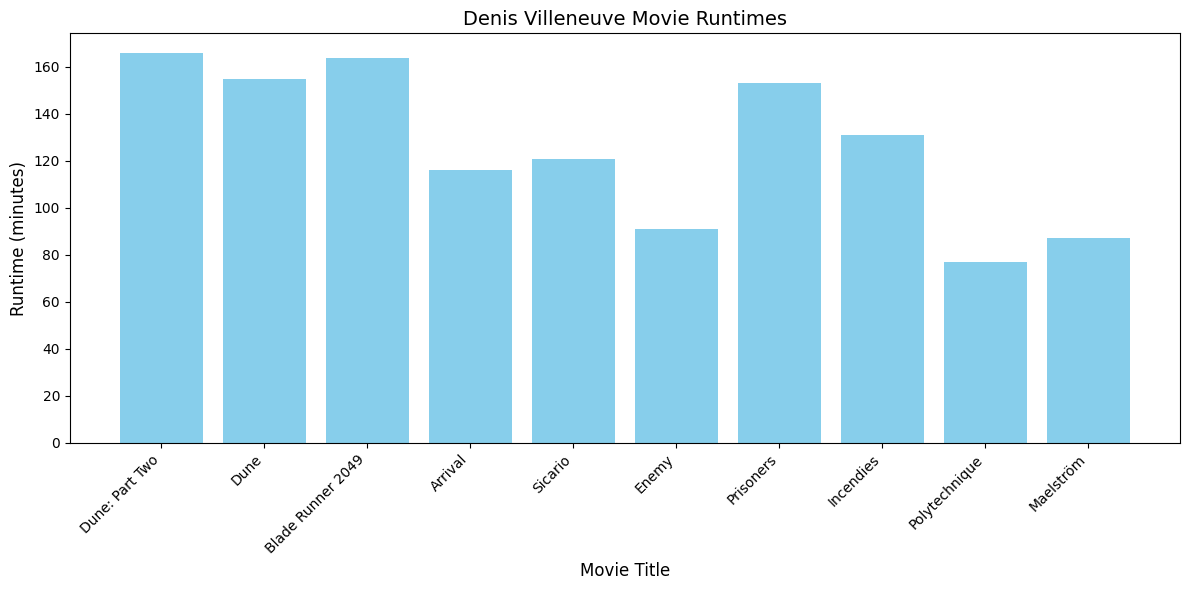

In [9]:
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes).
# Data gathered from search results.
movies = {
    "Dune: Part Two": 166,
    "Dune": 155,
    "Blade Runner 2049": 164,
    "Arrival": 116,
    "Sicario": 121,
    "Enemy": 91,
    "Prisoners": 153,
    "Incendies": 131,
    "Polytechnique": 77,
    "Maelström": 87
}

movie_titles = list(movies.keys())
runtimes = list(movies.values())

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='skyblue')

# Add labels and title
plt.xlabel("Movie Title", fontsize=12)
plt.ylabel("Runtime (minutes)", fontsize=12)
plt.title("Denis Villeneuve Movie Runtimes", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10) # Rotate x-axis labels for better fit
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()

One feature of using a chat conversation to do this is that you can now ask the model to make changes.

In [10]:
r = movie_chat.send_message('Looks great! Can you give the chart a dark theme instead?')
show_parts(r)

```python
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes)
movie_titles = [
    "Dune: Part Two",
    "Dune",
    "Blade Runner 2049",
    "Arrival",
    "Sicario",
    "Prisoners",
    "Enemy",
    "Incendies",
    "Polytechnique",
    "Maelström"
]

runtimes = [
    166,  # Dune: Part Two
    155,  # Dune
    164,  # Blade Runner 2049
    116,  # Arrival
    121,  # Sicario
    153,  # Prisoners
    91,   # Enemy
    139,  # Incendies
    77,   # Polytechnique
    87    # Maelström
]

# Apply a dark theme
plt.style.use('dark_background')

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='skyblue')  # Keep or change bar color as desired

# Customize the plot
plt.xlabel("Movie Title", color='white')  # Set label color to white for visibility
plt.ylabel("Runtime (minutes)", color='white')  # Set label color to white for visibility
plt.title("Runtimes of Last 10 Denis Villeneuve Movies", color='white')  # Set title color to white for visibility
plt.xticks(rotation=45, ha="right", color='white')  # Rotate x-axis labels and set color
plt.yticks(color='white')  # Set y-axis tick color to white

plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Display the plot
plt.show()
```



Key changes to implement the dark theme:

1.  **`plt.style.use('dark_background')`:** This is the primary line that applies a pre-defined dark background style to the plot.  Matplotlib has several built-in styles; 'dark\_background' is a good choice for this.  This affects the background color, axis colors, and other default settings.  It *must* be called before creating the plot elements.

2.  **Color Adjustments:** The `dark_background` style often sets the text and axis colors to a dark shade that might be difficult to read on a dark background. Therefore, I explicitly set the color of the following elements to white for better visibility:

    *   `plt.xlabel(..., color='white')`
    *   `plt.ylabel(..., color='white')`
    *   `plt.title(..., color='white')`
    *   `plt.xticks(..., color='white')`
    *   `plt.yticks(..., color='white')`

How to run:

1.  Save the code as a `.py` file (e.g., `villeneuve_dark_runtimes.py`).
2.  Run the code using `python villeneuve_dark_runtimes.py`.

This version will now display the bar chart with a dark background, making it visually distinct from the previous version. The text and axis labels will be white to ensure they are easily readable against the dark background.


Again, always be sure to review code generated by the model before running it.

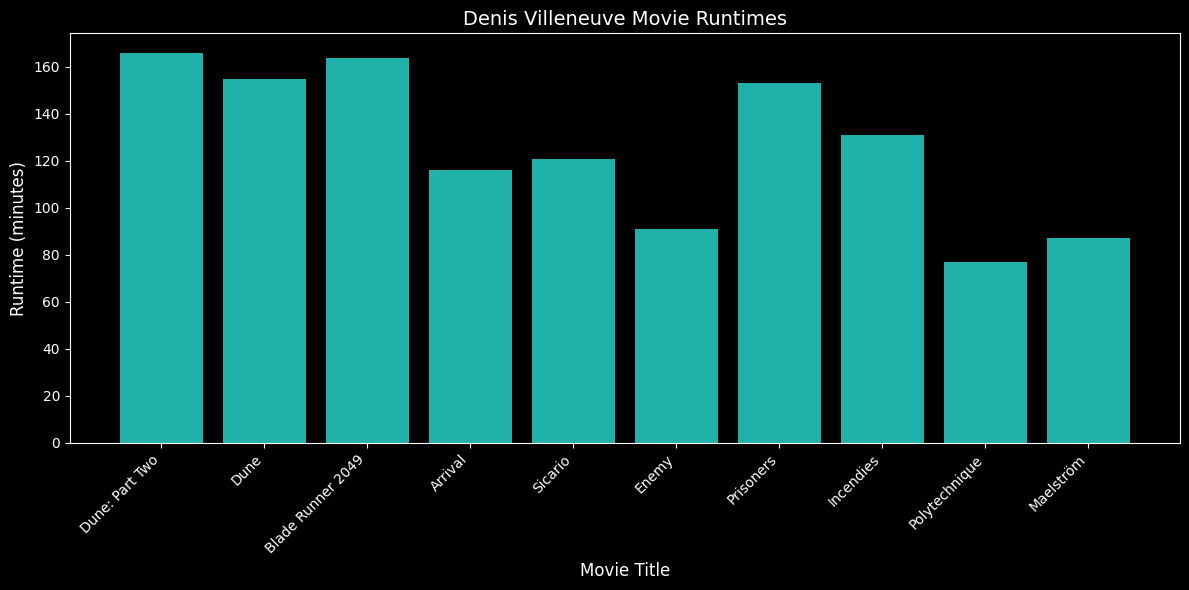

In [11]:
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes).
# Data gathered from search results.
movies = {
    "Dune: Part Two": 166,
    "Dune": 155,
    "Blade Runner 2049": 164,
    "Arrival": 116,
    "Sicario": 121,
    "Enemy": 91,
    "Prisoners": 153,
    "Incendies": 131,
    "Polytechnique": 77,
    "Maelström": 87
}

movie_titles = list(movies.keys())
runtimes = list(movies.values())

# Set dark theme
plt.style.use('dark_background')

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='lightseagreen') #changed bar color

# Add labels and title
plt.xlabel("Movie Title", fontsize=12, color='white')
plt.ylabel("Runtime (minutes)", fontsize=12, color='white')
plt.title("Denis Villeneuve Movie Runtimes", fontsize=14, color='white')
plt.xticks(rotation=45, ha="right", fontsize=10, color='white') # Rotate x-axis labels for better fit
plt.yticks(color='white')
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()


## Use search in the Multimodal Live API

The Search tool can be used in a live streaming context to have the model formulate grounded responses during the conversation.

### Define some helpers

To use the bi-directional streaming API in Colab, you will buffer the audio stream. Define a `play_response` helper function to do the buffering, and once the audio for the current turn has completed, display an IPython audio widget.

As each of the following examples only use a single prompt, also define a `run` helper to wrap the setup and prompt execution steps into a single function call. This helper takes a `config` argument that will be added to the `generation_config`, so that you can toggle the Search tool between examples.

In [12]:
import asyncio
import io
import json
import re
import time
import wave

import numpy as np
from IPython.display import Audio, display


DEFAULT_OUTPUT_RATE = 24000
BASE_MODEL_CONFIG = {
    'generation_config' : {
        # Here you can change the model's output mode between either audio or text.
        # While this code expects an audio stream, text should work, but the stream
        # may interleave with the `Buffering....` text.
        'response_modalities': ['AUDIO']
    },
}

async def play_response(stream):
  """Buffer audio output and display a widget. Returns the streamed responses."""
  turn_buf = io.BytesIO()
  sample_rate = DEFAULT_OUTPUT_RATE

  all_responses = []

  print('Buffering', end='')
  async for msg in stream.receive():
    all_responses.append(msg)

    if text:=msg.text:
      print(text)
    if audio_data := msg.data:
      turn_buf.write(audio_data)
      if m := re.search(
          'rate=(?P<rate>\d+)',
          msg.server_content.model_turn.parts[0].inline_data.mime_type
      ):
            sample_rate = int(m.group('rate'))

    elif tool_call := msg.tool_call:
      # Handle tool-call requests. Here is where you would implement
      # custom tool code, but for this example, all tools respond 'ok'.
      for fc in tool_call.function_calls:
        print('Tool call', end='')
        tool_response = genai.types.LiveClientToolResponse(
            function_responses=[genai.types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': 'ok'},
            )]
        )
        await stream.send(tool_response)

    print('.', end='')

  print()

  # Play the audio
  if turn_buf.tell():
    audio = np.frombuffer(turn_buf.getvalue(), dtype=np.int16)
    display(Audio(audio, autoplay=True, rate=sample_rate))
  else:
    print('No audio :(')
    print(f'  {len(all_responses)=}')

  return all_responses


async def run(query, config=None):
  # Add any tools or other generation config.
  config = BASE_MODEL_CONFIG | (config or {})

  # Establish a live session. While this context manager is active, the
  # conversation will continue.
  async with client.aio.live.connect(model=MODEL, config=config) as strm:

    # Send the prompt.
    await strm.send(query, end_of_turn=True)
    # Handle the model response.
    responses = await play_response(strm)

    return responses

### Stream with the Search tool

First, execute a query _without_ the Search tool to observe the model's response to a time-sensitive query.

Note that the Multimodal Live API is a 2-way streaming API, but to simplify running in a notebook, each audio response is buffered and played once it has been fully streamed, so you will need to wait a few seconds before the response starts to play.

In [14]:
await run('Who won the skateboarding gold medals in the 2024 olympics?');

TypeError: AsyncSession.send() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

Now re-run with the Search tool enabled.

In [15]:
responses = await run('Who won the skateboarding gold medals in the 2024 olympics?', {'tools': [search_tool]})

TypeError: AsyncSession.send() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

If you wish to see the full output that was returned, you can enable `show_output` here and run this cell. It includes the complete audio binary data, so it is off by default.

In [16]:
show_output = False

if show_output:
  for msg in responses:
    print(msg.model_dump(exclude_none=True))

### Search with custom tools

In the Multimodal Live API, the Search tool can be used in conjunction with other tools, including function calls that you provide to the model.

In this example, you define a function `set_climate` that takes 2 parameters, `mode` (`hot`, `cold`, etc) and `strength` (0-10), and ask the model to set the climate control based on the live weather in the location you specify.

In [17]:
set_climate_tool = {'function_declarations': [{
    'name': 'set_climate',
    'description': 'Switches the local climate control equipment to the specified parameters.',
    'parameters': {
      'type': 'OBJECT',
      'properties': {
        # Define the "mode" argument.
        'mode': {
            'type': 'STRING',
            'enum': [
              # Define the possible values for "mode".
              "hot",
              "cold",
              "fan",
              "off",
            ],
            'description': 'Mode for the climate unit - whether to heat, cool or just blow air.',
        },
        # Define the "strength" argument.
        'strength': {
            'type': 'INTEGER',
            'description': 'Intensity of the climate to apply, 0-10 (0 is off, 10 is MAX).',
        },
      },
    },
  },
]}

search_tool = {'google_search': {}}

tools = {'tools': [search_tool, set_climate_tool]}

responses = await run("Look up the weather in Paris and set my climate control appropriately.", tools)

TypeError: AsyncSession.send() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

Now inspect the `tool_call` response(s) you received during the conversation.

In [ ]:
for r in responses:
  if tool := r.tool_call:
    for fn in tool.function_calls:
      args = ', '.join(f'{k}={v}' for k, v in fn.args.items())
      print(f'{fn.name}({args})  # id={fn.id}')

set_climate(strength=7, mode=hot)  # id=function-call-6271898767513010323


## Next steps

<a name="next_steps"></a>

* For more demos showcasing multi-tool use in the Multimodal Live API, check out the [Plotting and Mapping cookbook](../examples/LiveAPI_plotting_and_mapping.ipynb).
* To get started with the Live API with the Python SDK, check out the [starter guide](./Get_started_LiveAPI.ipynb).
* To learn more about tool use in the Live API, check out the [Live API Tool Use cookbook](./Get_started_LiveAPI_tools.ipynb).

Also check the other Gemini 2.0 capabilities (like [spatial understanding](../quickstarts/Spatial_understanding.ipynb)) that you can find in the [Gemini Cookbook](https://github.com/google-gemini/cookbook/tree/main/gemini-2/).